In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
import random

from multiprocessing import Pool
import math

In [2]:
# Generating training and testing set.
hisDir = '/oasis/projects/nsf/csd395/ruogu/boosting/training_L0/';
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL'];
fileNames = os.listdir(hisDir);
Background = [np.load(hisDir + f) for f in fileNames if 'surround' in f];
NonBg = [(np.load(hisDir + f), labels.index(f[:-4])) for f in fileNames if 'surround' not in f];
X = [];
y = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);

bg = [];
for data in Background:
    for i in range(0, data.shape[0]):
        bg.append(data[i]);
# bg = random.sample(bg, 1000);

X = X + bg;
y = y + ([labels.index('BackG')] * len(bg));

X = np.asarray(X);
y = np.asarray(y);
raw_data = zip(X, y);
random.shuffle(raw_data);

quota = 0.8;
n_training = int(len(raw_data)*quota);
n_testing = len(raw_data) - n_training;
training_X = np.asarray([x[0] for x in raw_data[:n_training]]);
training_y = np.asarray([x[1] for x in raw_data[:n_training]]);
testing_X = np.asarray([x[0] for x in raw_data[n_training:]]);
testing_y = np.asarray([x[1] for x in raw_data[n_training:]]);

In [3]:
# Train in parallel.
def train_job(i):
    xi = training_X[i];
    his = 0.5 * np.sum(training_X + xi - np.abs(training_X - xi), axis=1); # Equals to min(xi, xj)
    return (i, his);

start = time();
pool = Pool(processes=15); # This is a compution-heavy work, so we can have more process, like 15.
result_train = pool.map(train_job, range(0, n_training));
end = time();
print "Kernel calculation takes {} sec.".format(end - start);
result_train = sorted(result_train, key=lambda x: x[0]);
myKernel = np.asarray([v[1] for v in result_train]);
myKernel = myKernel.reshape(n_training, n_training);

Kernel calculation takes 157.631520987 sec.


In [62]:
class BaseClassifier:
    def __init__(self, histogram, threshold, label, alpha, size, acc, index):
        self.h = histogram;
        self.t = threshold;
        self.l = label;
        self.alpha = alpha;
        self.size = size;
        self.acc = acc;
        self.index = index;
class Adaboost:    
    def __init__(self, iteration, n_class, stride, init_ball_size, enter_t, exit_t):
        self.clfs = [];
        self.t = iteration;
        self.n_class = n_class;
        self.stride = stride;
        self.init_ball_size = init_ball_size;
        self.enter_t = enter_t;
        self.exit_t = exit_t;

    # precomputed_score is the score matrix
    def fit(self, precomputed_scores, X, y):
        n_samples = precomputed_scores.shape[0];
        weights = np.zeros(n_samples);
        weights.fill(1.0 / n_samples);
        for t in range(0, self.t):
            # Choose example
            example_index = np.random.choice(range(n_samples), p=weights.tolist());
            example = X[example_index];
            # Calculate similarity scores
            scores = precomputed_scores[example_index];
            score_label_weight_index = zip(scores, y, weights, np.arange(n_samples));
            score_label_weight_index = sorted(score_label_weight_index, 
                                              key=lambda x: x[0], reverse=True);
            sorted_labels = [x[1] for x in score_label_weight_index];
            sorted_weights = [x[2] for x in score_label_weight_index];
            # Choose the plurality in the initial ball size
            count = np.bincount(sorted_labels[:self.init_ball_size], 
                                weights = sorted_weights[:self.init_ball_size]);
            label_of_interest = np.argmax(count);
            label_fraction = count[label_of_interest] / sum(sorted_weights[:self.init_ball_size]);
            
            if label_fraction < self.enter_t:
                # Discard this classifer
                continue;
            # Calculate threshold
            n_max = self.init_ball_size;
            for n in range(self.init_ball_size, n_samples, self.stride):
                # checkZero(n, "n");
                current_fraction = np.bincount(sorted_labels[:n],
                                               sorted_weights[:n])[label_of_interest] / sum(sorted_weights[:n]);
                if current_fraction > label_fraction:
                    n_max = n;
                    label_fraction = current_fraction;
            # Calculate alpha for this classifier
            abstained_weights = sum(sorted_weights[n_max:]);
            error = sum(sorted_weights[:n_max]) - np.bincount(sorted_labels[:n_max],
                                                              sorted_weights[:n_max])[label_of_interest];
            epsilon = 1.0E-10; # In case error is 0.
            alpha = 0.5 * math.log((1 - error + 0.5*abstained_weights) / (error + 0.5*abstained_weights));
            # Reweight samples that are affected
            for predicted_data in score_label_weight_index[:n_max]:
                if predicted_data[1] == label_of_interest: # Shrink correctly predicted
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp((-1.0)*alpha);
                else: # Enlarge wrongly predicted
                    weights[predicted_data[3]] = weights[predicted_data[3]] * math.exp(alpha);
            weights = weights / np.sum(weights); # Normalize weights.
            # Store this clf into clf list
            current_clf = BaseClassifier(example, score_label_weight_index[n_max][0], 
                                        label_of_interest, alpha, n_max, label_fraction, example_index);
            self.clfs.append(current_clf);
        
    def predict(self, X):
        prob = self.predict_proba(X);
        max_prob = np.max(prob, axis=1);
        labels = np.argmax(prob, axis=1);
        labels[max_prob==0] = -1;
        return labels;
        
    def predict_proba(self, X):
        if not self.clfs:
            raise ValueError("There is no classifiers.");
        n_samples = X.shape[0];
        prob = np.zeros(shape=(n_samples, self.n_class));
        for clf in self.clfs:
            score = 0.5 * np.sum(X + clf.h - np.abs(X - clf.h), axis=1);
            score[score < clf.t] = 0;
            score[score >= clf.t] = clf.alpha
            prob[:,clf.l] += score;
        return prob;

    def stage_predict(self, X):
        result = [];
        n_samples = X.shape[0];
        for i in range(0, len(self.clfs)):
            current_clfs = self.clfs[:i];
            prob = np.zeros(shape=(n_samples, self.n_class));
            for clf in current_clfs:
                score = 0.5 * np.sum(X + clf.h - np.abs(X - clf.h), axis=1);
                score[score < clf.t] = 0;
                score[score >= clf.t] = clf.alpha
                prob[:,clf.l] += score;
            max_prob = np.max(prob, axis=1);
            labels = np.argmax(prob, axis=1);
            labels[max_prob==0] = -1;
            result.append(labels);
        return result;

In [63]:
bst = Adaboost(iteration=1000, n_class=10, stride=10, init_ball_size=50, enter_t=0.5, exit_t=0.5);
t = time();
bst.fit(myKernel, training_X, training_y);
print "Fitting takes {} seconds.".format(time() - t);
print "{} useful classifers.".format(len(bst.clfs));

Fitting takes 1087.04032993 seconds.
306 useful classifers.


In [71]:
n_clf = len(bst.clfs);
clf_radius = [clf.size for clf in bst.clfs];
clf_acc = [clf.acc for clf in bst.clfs];
clf_alpha = [clf.alpha for clf in bst.clfs];
clf_index = [clf.index for clf in bst.clfs];

In [65]:
t = time();
train_staged_result = bst.stage_predict(training_X);
print "Training Staged predict time {}".format(time() - t);

Training Staged predict time 3805.08140898


In [66]:
train_staged_acc = [];
train_staged_acc_abstain=[];
train_abstain_rate = [];
for predicted_labels in train_staged_result:
    n_correct_train = 0;
    n_abstain_train = 0;
    for i in range(n_training):
        if predicted_labels[i] == -1:
            n_abstain_train += 1;
        if predicted_labels[i] == training_y[i]:
            n_correct_train += 1;
    train_staged_acc.append(1.0*n_correct_train / n_training);
    if n_training - n_abstain_train !=0:
        train_staged_acc_abstain.append(1.0*n_correct_train / (n_training - n_abstain_train));
    else:
        train_staged_acc_abstain.append(0);
    train_abstain_rate.append(1.0*n_abstain_train / n_training);

In [67]:
t = time();
test_staged_result = bst.stage_predict(testing_X);
print "Testing Staged predict time {}".format(time() - t);

Testing Staged predict time 564.745263815


In [68]:
test_staged_acc = [];
test_staged_acc_abstain=[];
test_abstain_rate = [];
for predicted_labels in test_staged_result:
    n_correct_test = 0;
    n_abstain_test = 0;
    for i in range(n_testing):
        if predicted_labels[i] == -1:
            n_abstain_test += 1;
        if predicted_labels[i] == testing_y[i]:
            n_correct_test += 1;
    test_staged_acc.append(1.0*n_correct_test / n_testing);
    if n_testing - n_abstain_test !=0:
        test_staged_acc_abstain.append(1.0*n_correct_test / (n_testing - n_abstain_test));
    else:
        test_staged_acc_abstain.append(0);
    test_abstain_rate.append(1.0*n_abstain_test / n_testing);

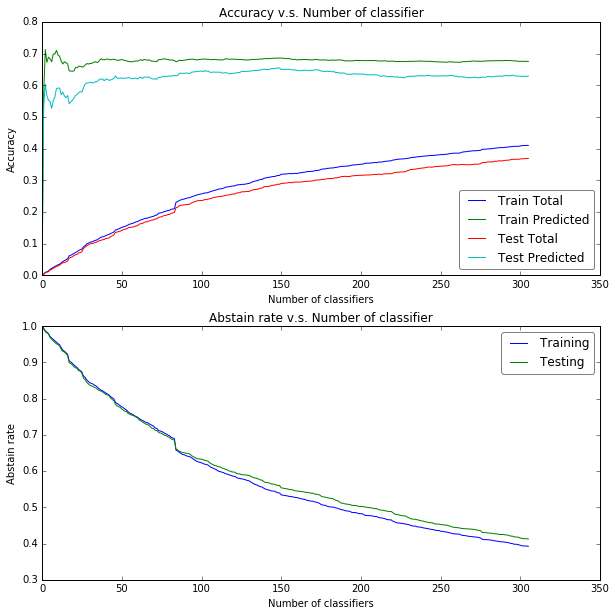

In [69]:
plt.figure(figsize=(10,10));
plt.subplot(211);
plt.title("Accuracy v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Accuracy");
plt.plot(range(0, n_clf), train_staged_acc, label='Train Total');
plt.plot(range(0, n_clf), train_staged_acc_abstain, label='Train Predicted');
plt.plot(range(0, n_clf), test_staged_acc, label='Test Total');
plt.plot(range(0, n_clf), test_staged_acc_abstain, label='Test Predicted');
plt.legend(loc='best', fancybox=True, framealpha=0.5);

plt.subplot(212);
plt.title("Abstain rate v.s. Number of classifier");
plt.xlabel("Number of classifiers");
plt.ylabel("Abstain rate");
plt.plot(range(0, n_clf), train_abstain_rate, label='Training');
plt.plot(range(0, n_clf), test_abstain_rate, label='Testing');
plt.legend(loc='best', fancybox=True, framealpha=0.5);

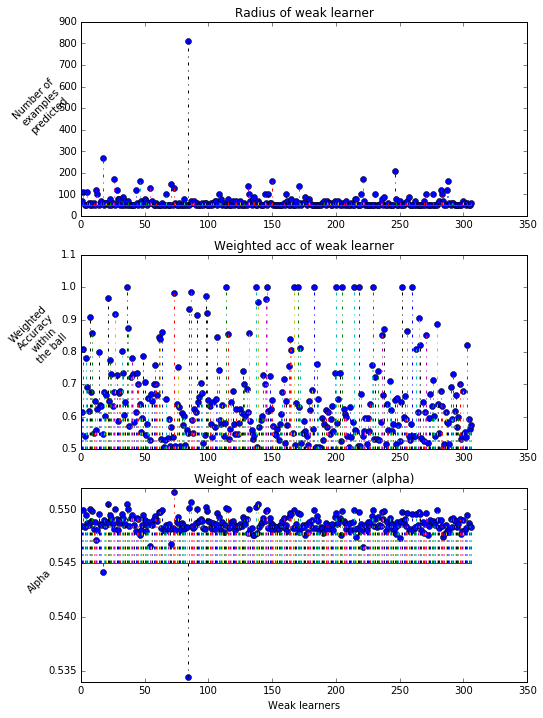

In [75]:
plt.figure(figsize=(8, 16));
plt.subplot(411);
plt.title("Radius of weak learner");
plt.ylabel("Number of\nexamples\npredicted", rotation=45);
plt.stem(range(1, n_clf + 1), clf_radius, '-.', bottom=50);

plt.subplot(412);
plt.title("Weighted acc of weak learner");
plt.ylabel("Weighted\nAccuracy\nwithin\nthe ball", rotation=45);
plt.stem(range(1, n_clf + 1), clf_acc, '-.', bottom=0.5);

plt.subplot(413);
plt.title("Weight of each weak learner (alpha)");
plt.xlabel("Weak learners");
plt.ylabel("Alpha", rotation=45);
plt.stem(range(1, n_clf + 1), clf_alpha, '-.', bottom=0.545);

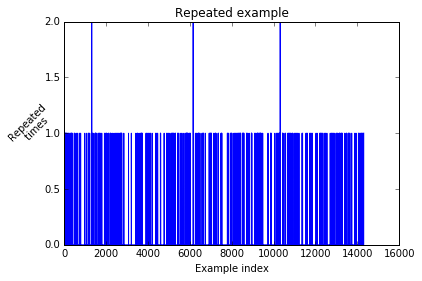

In [83]:
unique_example = np.bincount(np.array(clf_index));
plt.subplot(111);
plt.title("Repeated example");
plt.xlabel("Example index");
plt.ylabel("Repeated\n times", rotation=45);
plt.plot(unique_example);